# Evolution Algorithm
In this notebook, we are going to be focusing on the EvolutionAlgorithm in the evolution_algorithm module in PAI-Utils.

## Import Packages

In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython import display

from paiutils import neural_network as nn
from paiutils import evolution_algorithm as ea
from paiutils.reinforcement_agents import Continuous

# see if using GPU and if so enable memory growth
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Create Environment
We will test the EvolutionAlgorithm by using it to tune a neural network to play Pendulum-v0. For more information about the environment, click [this](https://github.com/openai/gym/wiki/Pendulum-v0)

In [2]:
genv = gym.make('Pendulum-v0')
max_steps = genv._max_episode_steps
print(max_steps)
print(genv.observation_space, genv.action_space)
low = genv.action_space.low
high = genv.action_space.high
state_shape = genv.observation_space.shape[0]
action_size = genv.action_space.shape[0]

def play_episodes(amodel, num_episodes, render=False):
    global genv, max_steps
    total_rewards = 0
    img = None
    for episode in range(1, num_episodes + 1):
        state = genv.reset()
        total_reward = 0
        for step in range(max_steps):
            if render:
                x = genv.render(mode='rgb_array')
                if img is None:
                    img = plt.imshow(x)
                else:
                    img.set_data(x)
                plt.axis('off')
                display.display(plt.gcf())
                display.clear_output(wait=True)
            action = amodel(np.expand_dims(state, axis=0),
                            training=False)[0].numpy()
            state, reward, terminal, _ = genv.step(action)
            total_reward += reward
            if terminal:
                break
        total_rewards += total_reward
    return total_rewards / num_episodes

200
Box(-8.0, 8.0, (3,), float32) Box(-2.0, 2.0, (1,), float32)


## Create the Model

In [3]:
inputs = keras.layers.Input(shape=state_shape)
x = keras.layers.Dense(32, activation='relu')(inputs)
x = keras.layers.Dense(32, activation='relu')(x)
action = keras.layers.Dense(action_size, activation='tanh')(x)
action = Continuous.scale(low, high)(action)
action = Continuous.clip(low, high)(action)

amodel = keras.Model(inputs=inputs,
                     outputs=action)
amodel.summary()

shapes_sizes = [(x.shape, np.prod(x.shape)) for x in amodel.get_weights()]
num_params = sum([size for _, size in shapes_sizes])
init_flat_weights = np.hstack(
    [x.flatten() for x in amodel.get_weights()]
)
print(shapes_sizes, num_params)

def set_model_weights(flat_weights):
    global amodel, shapes_sizes
    assert len(flat_weights) == num_params
    
    weights = []
    for shape, size in shapes_sizes:
        weight = flat_weights[:size]
        flat_weights = flat_weights[size:]
        weights.append(np.reshape(weight, shape))
    amodel.set_weights(weights)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
_________________________________________________________________
tf_op_layer_Mul (TensorFlowO [(None, 1)]               0         
_________________________________________________________________
tf_op_layer_AddV2 (TensorFlo [(None, 1)]               0         
_________________________________________________________________
tf_op_layer_AddV2_1 (TensorF [(None, 1)]              

## Create Evaluation Function

In [4]:
def create_fitness_func(num_episodes):
    global amodel
    def fitness_func(offspring):
        fitnesses = []
        for genes in offspring:
            set_model_weights(genes)
            fitnesses.append(
                play_episodes(amodel, num_episodes)
            )
        return np.array(fitnesses)
    return fitness_func

## Create Evolution Algorithm

In [5]:
mutation_rates = np.full(num_params, .3)
distributions = [(0, 1) for _ in range(num_params)]

evoalgo = ea.EvolutionAlgorithm(
    create_fitness_func(4),
    ea.Selection.select_highest(),
    ea.Mutation.additive(mutation_rates, distributions),
    ea.Crossover.single()
)

## Simulate Natural Selection

In [6]:
base_genome = init_flat_weights
generations = 10
population = 200
selection_size = 10

results = evoalgo.simulate(
    base_genome, generations,
    population, selection_size,
    return_all_genomes=True, verbose=True
)
results = sorted(results, key=lambda x: x[0])
best_score, best_weights = results[-1]
print(results)
print(best_score)
np.save('weights', best_result)

Generation 1
Highest Fitness: -667.7251483891166 - Lowest Fitness: -1817.782537174931 - Mean Fitness: -1476.2981443543665
Generation 2
Highest Fitness: -731.5962202986071 - Lowest Fitness: -1785.2196397376433 - Mean Fitness: -1445.620161007253
Generation 3
Highest Fitness: -380.7716850058321 - Lowest Fitness: -1754.8768866409453 - Mean Fitness: -1451.1740495197646
Generation 4
Highest Fitness: -310.85998180889527 - Lowest Fitness: -1668.0754288653907 - Mean Fitness: -1426.4101935189776
Generation 5
Highest Fitness: -672.7176711035456 - Lowest Fitness: -1742.330957657079 - Mean Fitness: -1396.832350661775
Generation 6
Highest Fitness: -359.28917626988726 - Lowest Fitness: -1659.0917275642676 - Mean Fitness: -1362.1201391817292
Generation 7
Highest Fitness: -688.9940568593325 - Lowest Fitness: -1636.4084514053445 - Mean Fitness: -1371.4363898708707
Generation 8
Highest Fitness: -361.8815787354672 - Lowest Fitness: -1832.3639528683418 - Mean Fitness: -1356.1268194432341
Generation 9
Highe

NameError: name 'best_result' is not defined

## Test the Agent

-153.1674381188468

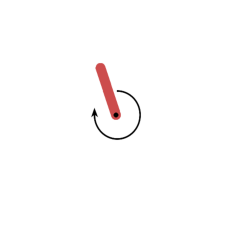

In [7]:
set_model_weights(best_weights)
play_episodes(amodel, 1, render=True)

### 100-Episode Average

In [8]:
print(play_episodes(amodel, 100))

-952.5198101585084


As we can see with this very low score, the tunned model only seems to have worked for a small subset of random start positions. We can potentially resolve this by increasing the number of episodes used in the evaluation, but that would dramatically slow down the tunning.